# Large Model Support

### What is LMS?

Large Model Support (LMS) is a feature provided in Watson Machine Learning Community Edition (WML-CE) for the deep learning frameworks TensorFlow and PyTorch. LMS allows the successful training of deep learning models that would otherwise exhaust GPU memory and abort with “out-of-memory” errors.

LMS manages this oversubscription of GPU memory by temporarily swapping tensors to host memory when they are not needed.

One or more elements of a deep learning model can lead to GPU memory exhaustion. These include:

- Model depth and complexity
- Base data size (for example, high-resolution images)
- Batch size

Traditionally, the solution to this problem has been to modify the model until it fits in GPU memory. This approach, however, can negatively impact accuracy – especially if concessions are made by reducing data fidelity or model complexity.

With LMS, deep learning models can scale significantly beyond what was previously possible and, ultimately, generate more accurate results.

### Availability

WML CE is available for both POWER and x86 platforms, however features/packages such as LMS will not be as performant on non-POWER accelerated computing platforms. The full list of pre-requisites, and requirements can be found [here](https://www.ibm.com/support/knowledgecenter/SS5SF7_1.6.1/navigation/wmlce_req.html).

### Useful links:

[WML-CE home page](https://www.ibm.com/support/knowledgecenter/SS5SF7_1.6.1/navigation/welcome.html)

[Getting Started with TensorFlow LMS](https://www.ibm.com/support/knowledgecenter/SS5SF7_1.6.1/navigation/wmlce_getstarted_tflmsv2.html)

[Getting Started with PyTorch LMS](https://www.ibm.com/support/knowledgecenter/SS5SF7_1.6.1/navigation/wmlce_getstarted_pytorch.html)

## TensorFlow LMS Hands-On

In this example we are going to train a Keras ResNet 50 model on randomly generated images. This allows us to control the size of the images, therefore letting us push the image resolution far beyond GPU memory limits. 

### Without LMS...

In [1]:
# Importing the relevant packages.
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
 
# Testing that a GPU is available.
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


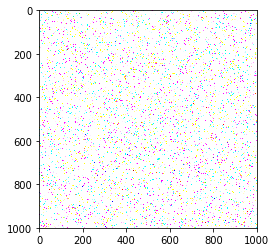

In [2]:
def random_image_generator(batch_size, num_classes, input_shape):
    # This generator yields batches of randomly generated images and categories.
    # The random generation parts came from
    # https://github.com/tensorflow/tensorflow/blob/v1.12.0/tensorflow/python/keras/testing_utils.py#L29

    templates = 2 * num_classes * np.random.random((num_classes,) + input_shape)
    random_data = np.random.normal(loc=0, scale=1., size=input_shape)
    while True:
        y = np.random.randint(0, num_classes, size=(batch_size,))
        x = np.zeros((batch_size,) + input_shape, dtype=np.float32)
        for i in range(batch_size):
            x[i] = templates[y[i]] + random_data
        x_array = np.array(x)
        y_array = tf.keras.utils.to_categorical(y, num_classes)
        yield(x_array, y_array)

batch_size = 10
num_classes = 15

# To trigger LMS you will want to alter the image_dim
image_dim = 1000
input_shape = (image_dim, image_dim, 3)

# Creating the generator object.
image_generator = random_image_generator(batch_size, num_classes, input_shape)

# Iterating over the generated images, and grabbing the final instance.
# Then visualising that image.
single_instance = next(image_generator)
plt.imshow(single_instance[0][0], cmap="gray")
plt.show()

In [3]:
resnet50 = tf.keras.applications.ResNet50(weights=None, include_top=True,
                                              input_shape=input_shape,
                                              classes=num_classes)

# resnet50 is a tf.keras.engine.training.Model which we then compile with
# an appropriate optimizer and loss function.
resnet50.compile(optimizer='rmsprop', loss='categorical_crossentropy')

steps_per_epoch = 10
verbose = 1
epochs = 2

# Running the compiled model against the image_generator object, passing in the
# hyperparameters defined above, as well as the all important LMS callback.
resnet50.fit_generator(image_generator, steps_per_epoch=steps_per_epoch,
                           epochs=epochs, verbose=verbose)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
Train for 10 steps
Epoch 1/2
 1/10 [==>...........................] - ETA: 3:47

ResourceExhaustedError:  OOM when allocating tensor with shape[1024,256,1,1] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node resnet50/conv4_block4_3_conv/Conv2D (defined at <ipython-input-3-3bda4fcb129b>:16) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_distributed_function_19993]

Function call stack:
distributed_function


In [ ]:
# TensorFlow and Jupyter do not play nicely together all of the time. 
# As Jupyter freezes a session's state after each cell execution TensorFlow does not release
# the GPU memory when the job has executed. Therefore, the kernel has to be reset.
os._exit(00)

### Now with LMS!

Go back and re-import the packages, and re-generate the data required, then pop back down to the LMS modifications!

In the below cell we will do the following:
- Import the TF LMS module
- Set a simulator environment variable
- Instantiate the LMS object
- Make LMS aware of the batch size being used

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
tf.config.experimental.set_lms_enabled(True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


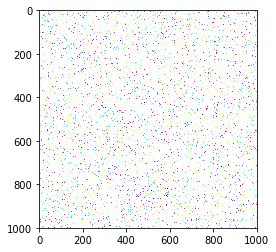

In [2]:
def random_image_generator(batch_size, num_classes, input_shape):
    # This generator yields batches of randomly generated images and categories.
    # The random generation parts came from
    # https://github.com/tensorflow/tensorflow/blob/v1.12.0/tensorflow/python/keras/testing_utils.py#L29

    templates = 2 * num_classes * np.random.random((num_classes,) + input_shape)
    random_data = np.random.normal(loc=0, scale=1., size=input_shape)
    while True:
        y = np.random.randint(0, num_classes, size=(batch_size,))
        x = np.zeros((batch_size,) + input_shape, dtype=np.float32)
        for i in range(batch_size):
            x[i] = templates[y[i]] + random_data
        x_array = np.array(x)
        y_array = tf.keras.utils.to_categorical(y, num_classes)
        yield(x_array, y_array)

batch_size = 10
num_classes = 15

# To trigger LMS you will want to alter the image_dim
image_dim = 1000
input_shape = (image_dim, image_dim, 3)

# Creating the generator object.
image_generator = random_image_generator(batch_size, num_classes, input_shape)

# Iterating over the generated images, and grabbing the final instance.
# Then visualising that image.
single_instance = next(image_generator)
plt.imshow(single_instance[0][0], cmap="gray")
plt.show()

In [3]:
new_resnet50 = tf.keras.applications.ResNet50(weights=None, include_top=True,
                                              input_shape=input_shape,
                                              classes=num_classes)

new_resnet50.compile(optimizer='rmsprop', loss='categorical_crossentropy')

steps_per_epoch = 10
verbose = 1
epochs = 2

model = new_resnet50.fit_generator(image_generator, steps_per_epoch=steps_per_epoch,
                           epochs=epochs,
                           verbose=verbose)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
Train for 10 steps
Epoch 1/2
10/10 [==============================] - 35s 3s/step - loss: 5.7581
Epoch 2/2
10/10 [==============================] - 8s 844ms/step - loss: 2.3624


In [4]:
model.history

{'loss': [5.758135652542114, 2.362358033657074]}